In [1]:
%matplotlib notebook    
import numpy as np
import scipy.integrate as integrate
import control.matlab as co
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
from matplotlib.widgets import Slider

In [2]:
def statespace(y,t):
    
    """ Creates State vector from given initial conditions.
        State Linear vector follows the equation Xdot = AX. This function creates the vector using
        the dynamic model of the system. This vector is passed through scipy.integrate.odeint functin
        which will integrate the vector and output states similar to ode45 in MATLAB.
        
        inputs:
            y = state vector that will be calculated by odeint
            t = time vector
            
        returns:
            dydt = State Vector
    
    Note: The dynamic model of the system is referred from Prof. Steven L. Brunton's youtube series Control Bootcamp.
    """
    
    Sy = np.sin(y[2])           # Assigning a variable for sin theta for simplicity in writing equations
    Cy = np.cos(y[2])           # Assigning a variable for sin theta for simplicity in writing equations
    D = m*L*L*(M+m*(1-Cy**2))   # Denominator of the equations of motion
    
    dydt = np.zeros_like(y)     # Creating dydt vector same size/shape as y
    
    """ Arrays and matrices are treated differently in numpy and therefore need to be treated differently. 
    We need to calculate the input u to the states and therefore need to convert the vectors to the same data type 
    before proceeding"""
    
    y_mat = np.matrix([[y[0]],[y[1]],[y[2]],[y[3]]])     
    
    inp = -K*(y_mat-yd_mat)
    u = inp[0,0] # We cannot directly use inp to multiply in the equations and need to extract it from the 1x1 inp matrix
    
    # State Equations
    dydt[0] = y[1]
    dydt[1] = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*y[3]**2*Sy - d*y[1])) + m*L*L*(1/D)*u
    dydt[2] = y[3]
    dydt[3] = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*y[3]**2*Sy - d*y[1])) - m*L*Cy*(1/D)*u 
    
    return dydt

In [3]:
def animate(i):
    """
    This function takes in the value from Sliders and updates the graph animation. The way this animation function works is
    similar to drawnow in matlab. It continuously plots the data and makes it look like an animation. 
    
    The code below uses the updated y vector that will be imported from the main body or update() function and sets the
    initial position of the cart, wheels and pendulum. We need to plot them separately and make it look like a pendulum
    on a cart.    
    """
    
    cart.set_data([y[i,0]-3,y[i,0]+3], [0.5,0.5])
    wheel1.set_data([y[i,0]-2],0.25)
    wheel2.set_data([y[i,0]+2],0.25)
    
    pend_rod.set_data([y[i,0], y[i,0]+L*np.sin(y[i,2])],[0.5,1 - L*np.cos(y[i,2])])
    pend.set_data(y[i,0] + L*np.sin(y[i,2]) ,1 - L*np.cos(y[i,2]))
    
    time_text.set_text(time_template % (i*0.1))


In [4]:
def update(i):
    
    """
    This funtion is executed when the sliders are moved. 
    """
    ani.event_source.start(1)
    global xx,theta,y0,yd,yd_mat,y #Global so that the updated versions can be accessed in other functions.
    
    theta = s_th.val   # Assigning the new theta value from the slider
    xx = s_xx.val      # Assigning the x-position of the cart
   
    #Assigning the end position of previous y as new initial positions so the animation appears continuous
    y0 = np.array([y[-1,0],0,theta,0])   
    yd = np.array([xx,0,np.pi,0])
    yd_mat = np.matrix([[yd[0]],[yd[1]],[yd[2]],[yd[3]]])
    
    #Integrating to obtain updated y
    y = integrate.odeint(statespace,y0,t)
    
    #The lines below restart the animation once it is over
    ani.new_frame_seq()
    ani.event_source.start(1)
    

<IPython.core.display.Javascript object>


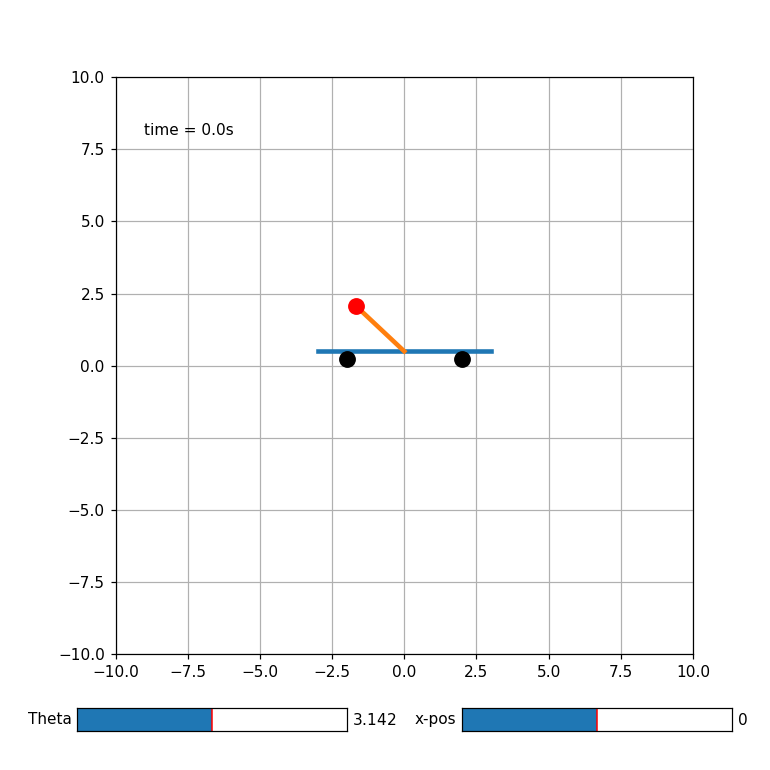

In [5]:
# This is the main body of the program where everything is executed

m = 1       # Mass of the Pendulum
M = 5       # Mass of the Cart
L = 2       # Length of the Pendulum
g = -10     # Acc. Due to gravity
d = 1       # Damping

# Defining linearized state space model below and calculating state feedback control gains for optimal control

A = np.array([[0,1,0,0],[0,-d/M,-m*g/M,0],[0,0,0,1],[0,-d/(M+L),-(m+M)*g/(M+L),0]])
B = np.array([[0],[1/M],[0],[1/(M*L)]])

Q = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,10,0],[0,0,0,100]])
R = 0.0001

[K,S,E] = co.lqr(A,B,Q,R)
Kf = np.array([K[0,0],K[0,1],K[0,2],K[0,3]])

# Initializing the first base run

y0 = np.array([0,0,np.pi+1,0])
yd = np.array([0,0,np.pi,0])
yd_mat = np.matrix([[yd[0]],[yd[1]],[yd[2]],[yd[3]]])

#Creating time vector
T_final = 15
t = np.arange(0,T_final,0.1)

# Integrating and getting state vector
y = integrate.odeint(statespace,y0,t)

# Creating the Figure
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, position=[.15,.15,.75,.75] )
ax.grid()

# setting the axis to the max displacement x so the whole cart is visible
#ax.set_xlim(-(np.amax(np.absolute(y[:,0])))*1.2, (np.amax(np.absolute(y[:,0])))*1.2)
#ax.set_ylim(-(np.amax(np.absolute(y[:,0])))*1.2, (np.amax(np.absolute(y[:,0])))*1.2)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])

# Drawing the parts of the system
cart_x = y[0,0]
cart, = ax.plot([cart_x-3,cart_x+3],[0.5,0.5], linewidth = 3)
wheel1, = ax.plot(cart_x-2,[0.25],'ok',ms = 10)
wheel2, = ax.plot(cart_x+2,[0.25],'ok',ms = 10)

pend_x = cart_x + L*np.sin(y[0,2])
pend_y = 1 - L*np.cos(y[0,2])
pend_rod, = ax.plot([cart_x,pend_x],[0.5,pend_y],linewidth = 3)
pend, = ax.plot(pend_x,pend_y,'ro',ms = 10)

time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ax_th = plt.axes([0.1, 0.05, 0.35, 0.03])
ax_xx = plt.axes([0.6, 0.05, 0.35, 0.03])

#Creating Sliders
s_th = Slider(ax_th, r'Theta', np.pi-1, np.pi+1, valinit=np.pi, valstep=0.05)
s_xx = Slider(ax_xx, r'x-pos', -10, 10, valinit=y[0,0], valstep=1)

#Slider update functions
s_th.on_changed(update)
s_xx.on_changed(update)
ani = FuncAnimation(fig, animate,frames = len(t), interval=10, repeat = True)